In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.svm import SVC

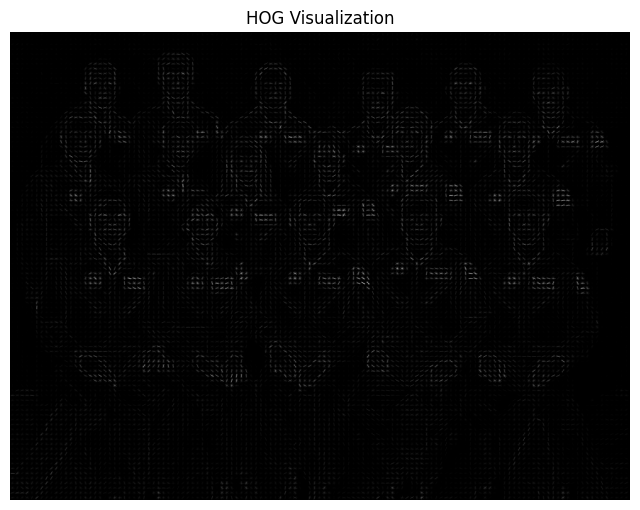

In [6]:
from skimage import io, color
from skimage.feature import hog
# Load image
image = io.imread("NASA_Astronaut_Group_18.jpg")

# Convert to grayscale (HOG works on single channel)
gray = color.rgb2gray(image)

# Compute HOG and visualization
features, hog_image = hog(
    gray,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True
)

# Display
plt.figure(figsize=(8, 8))
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.title("HOG Visualization")
plt.show()